In [ ]:
from __future__ import annotations
import numpy as np
import keras
from sklearn.metrics import f1_score
from time import time
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Tuple

from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
(
    (train_images, train_labels),
    (test_images, test_labels),
) = mnist.load_data()

train_images, _, train_labels, _ = train_test_split(train_images, train_labels, train_size=7000, stratify=train_labels, random_state=1)
test_images, _, test_labels, _ = train_test_split(test_images, test_labels, train_size=3000, stratify=test_labels, random_state=1)

train_images = (
    train_images.reshape((7000, 28, 28, 1)).astype("float32") / 255
)
test_images = (
    test_images.reshape((3000, 28, 28, 1)).astype("float32") / 255
)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
class Individual:
    """A class that represents the individual of the population, enconding
        parameters of a neural network.

    Attributes:
        generation (int): Represents which generation this individual was
            created.
        genome (list): The genome of the individual, encoding parameters
            for the neural network.
        metrics (dict): The metrics of the evaluated neural network
            (accuracy, loss, f1_score, latency, weights_norm).
        model (keras.Sequential): Neural Network Model created by the
            genome encoded properties.
    """

    def __init__(self, generation: int = 0) -> None:
        """
        Initialize the Individual with its genome, generation and metrics.

        Args:
            genome (list): The genome of the individual.
            fitness (float): The fitness score of the individual.
        """
        self.generation = generation
        self.genome = [0 if np.random.random() < 0.5 else 1 for _ in range(12)]
        self.metrics = {}

    def _evaluate(
        self,
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: np.ndarray,
        y_test: np.ndarray,
    ) -> None:
        """
        Evaluate the individual's neural network model using the provided data.

        This method constructs a neural network based on the individual's genome
        and evaluates its performance using the given training and testing datasets.

        Args:
            X_train (numpy.ndarray): Training input data.
            X_test (numpy.ndarray): Testing input data.
            y_train (numpy.ndarray): Training target data (labels).
            y_test (numpy.ndarray): Testing target data (labels).

        Returns:
            None

        Example:
            individual._evaluate(X_train, X_test, y_train, y_test)
        """
        # Set seed for reproductibility of the models with the same genome
        seed = int("".join(map(str, self.genome)), 2)
        np.random.seed(seed)
        tf.random.set_seed(seed)

        self.model = keras.Sequential()
        self.model.add(
            keras.layers.Conv2D(
                2
                ** (
                    int("".join(map(str, self.genome[2:4])), 2) + 4
                ),  # Maps the number of neurons in the first conv layer
                (3, 3),
                activation="relu",
                input_shape=(28, 28, 1),
            )
        )
        self.model.add(keras.layers.MaxPooling2D((2, 2)))
        for i in range(
            1, int("".join(map(str, self.genome[0:2])), 2)
        ):  # Maps the number of conv layers
            self.model.add(
                keras.layers.Conv2D(
                    2
                    ** (
                        int("".join(map(str, self.genome[2:4])), 2) + 4
                    ),  # Maps the number of neurons of all conv layers
                    (3, 3),
                    activation="relu",
                )
            )
            # Create max pool layers after a odd number of layers
            if (i % 2) != 0:
                self.model.add(keras.layers.MaxPooling2D((2, 2)))

        self.model.add(keras.layers.Flatten())
        for _ in range(
            int("".join(map(str, self.genome[4:6])), 2) + 1
        ):  # Maps the number of dense layers
            self.model.add(
                keras.layers.Dense(
                    int("".join(map(str, self.genome[6:12])), 2)
                    + 1,  # Maps the number neurons in the dense layers
                    activation="relu",
                )
            )
        self.model.add(keras.layers.Dense(10, activation="softmax"))

        self.model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"],
        )
        self.model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=64,
            validation_split=0.2,
            verbose=False,
        )
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=False)
        self.metrics["loss"] = (1, loss)
        self.metrics["accuracy"] = (-1, accuracy)

        # Get the weights on the trainable layers
        weights = self.model.get_weights()
        self.metrics["weights_norm"] = (
            1,
            sum([np.linalg.norm(w) for w in weights]),
        )
        start = time()
        y_pred = self.model.predict(X_test, verbose=False)
        end = time()
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test, axis=1)
        self.metrics["f1_score"] = (
            -1,
            f1_score(y_test, y_pred, average="macro"),
        )

        # Latency is calculated by the avarege execution time
        self.metrics["latency"] = (1, (end - start) / 3000)

    def crossover(self, other_individual: Individual) -> list[Individual]:
        """Performs crossover between the current individual and another individual.

        This method combines genetic material from the current individual and
        the provided other_individual to generate new children individuals.

        Args:
            other_individual (Individual): the second individual to crossover with

        Returns:
            list[Individual]: list containing the two individuals from the crossover

        Example:
            children = individual.crossover(other_individual)
        """
        # Performs a single cut in a random gene on the genome
        cut = round(np.random.rand() * len(self.genome))
        child1 = other_individual.genome[0:cut] + self.genome[cut::]
        child2 = self.genome[0:cut] + other_individual.genome[cut::]

        # Represents the advancement of the generation
        children = [
            Individual(self.generation + 1),
            Individual(self.generation + 1),
        ]
        children[0].genome = child1
        children[1].genome = child2

        return children

    def mutation(self, mutation_rate: float) -> Individual:
        """Apply mutation to the individual's genome.
        Apply mutation to the individual.

        Args:
            mutation_rate (float): The probability of mutation for each gene.

        Returns:
            Individual: A new individual with mutations applied.

        Example:
            individual_mutated = individual.mutation(0.05)
        """
        for i in range(len(self.genome)):
            if np.random.random() < mutation_rate:
                if self.genome[i]:
                    self.genome[i] = 0
                else:
                    self.genome[i] = 1
        return self

    def __repr__(self):
        return f"""Generation: {self.generation}
Gene: {self.genome}
{int("".join(map(str, self.genome[0:2])), 2) + 1} camadas convolucionais com {int("".join(map(str, self.genome[2:4])), 2) + 1} neurons
{int("".join(map(str, self.genome[4:6])), 2) + 1} camadas densas com {int("".join(map(str, self.genome[6:12])), 2) + 1} neurons
"""

In [ ]:
class GeneticAlgorithm:
    """A class representing a genetic algorithm for optimization of Neural Networks.

    Attributes:
        population_size (int): The size of the population.
        population (list): The list of individuals in the population.
        generation (int): The current generation number.
        best_solution (Individual): The best solution found.
        X_train: Training data for the genetic algorithm.
        X_test: Testing data for the genetic algorithm.
        y_train: Training labels for the genetic algorithm.
        y_test: Testing labels for the genetic algorithm.
        pareto (list): A list of individuals representing the Pareto frontier.
        frontier (list): A list of fronts of non-dominated solutions.
        fo (str): The name of the first objective.
        fo_threshold (float): The threshold for the first objective.
        so (str): The name of the second objective.
        so_threshold (float): The threshold for the second objective.
    """

    def __init__(
        self,
        population_size: int,
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: np.ndarray,
        y_test: np.ndarray,
        first_objective: Tuple[str, int],
        second_objective: Tuple[str, int],
    ) -> None:
        """Initializes a GeneticAlgorithm instance with the provided parameters.

        Args:
            population_size (int): The size of the population.
            X_train: Training data for the genetic algorithm.
            X_test: Testing data for the genetic algorithm.
            y_train: Training labels for the genetic algorithm.
            y_test: Testing labels for the genetic algorithm.
            first_objective: A tuple containing the name and threshold for the first objective.
            second_objective: A tuple containing the name and threshold for the second objective.

        Returns:
            None
        """
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.best_solution = None
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []
        self.frontier = []
        self.fo = first_objective[0]
        self.fo_threshold = first_objective[1]
        self.so = second_objective[0]
        self.so_threshold = second_objective[1]

    def init_population(self) -> None:
        """Initializes the population of individuals.

        Returns:
            None
        """
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        """Sorts the population based on a specified fitness metric.

        Returns:
            None
        """
        self.population = sorted(
            self.population,
            key=lambda individual: individual.metrics[self.fo][0]
            * individual.metrics[self.fo][1],
            reverse=True,
        )

    def best_individual(self, pareto: list[Individual]) -> Individual:
        """Finds the best individual from a Pareto front based on specified fitness metrics.

        Args:
            pareto (list[Individual]): List of individuals representing the Pareto front.

        Returns:
            Individual: The best individual from the Pareto front.
        """
        first_minimum = min(
            pareto, key=lambda x: x.metrics[self.fo][0] * x.metrics[self.fo][1]
        )

        # Threshold is min + threshold(%)
        first_threshold = first_minimum.metrics[self.fo][1] * self.fo_threshold
        low_bound = (
            first_minimum.metrics[self.fo][0]
            * first_minimum.metrics[self.fo][1]
            - first_threshold
        )
        high_bound = (
            first_minimum.metrics[self.fo][0]
            * first_minimum.metrics[self.fo][1]
            + first_threshold
        )

        # Subset containing the solutions between the minimum of the first objective and its threshold
        interval = [
            individual
            for individual in pareto
            if low_bound
            <= individual.metrics[self.fo][0] * individual.metrics[self.fo][1]
            <= high_bound
        ]
        second_minimum = min(
            interval,
            key=lambda x: x.metrics[self.so][0] * x.metrics[self.so][1],
        )
        second_threshold = (
            second_minimum.metrics[self.so][1] * self.so_threshold
        )
        low_bound = (
            second_minimum.metrics[self.so][0]
            * second_minimum.metrics[self.so][1]
            - second_threshold
        )
        high_bound = (
            second_minimum.metrics[self.so][0]
            * second_minimum.metrics[self.so][1]
            + second_threshold
        )

        # Subset containing the solutions between the minimum of the second objective and its threshold
        interval2 = [
            individual
            for individual in interval
            if low_bound
            <= individual.metrics[self.so][0] * individual.metrics[self.so][1]
            <= high_bound
        ]
        if len(interval2) == 1:
            return second_minimum
        else:
            return min(
                interval2,
                key=lambda x: x.metrics[self.fo][0] * x.metrics[self.fo][1],
            )

    def select_parent(self, size: int) -> int:
        """Selects a parent index randomly from the range [0, size).

        Args:
            size (int): The size of the population.

        Returns:
            int: The index of the selected parent.
        """
        return np.random.randint(size)

    def visualize_generation(self, best: Individual) -> None:
        """Visualizes the best individual's information for a specific generation.

        Prints the generation number, fitness metrics, and genome of the best individual.

        Args:
            best (Individual): The best individual in the generation.

        Returns:
            None
        """
        print(
            f"G:{best.generation}:\n",
            f"{self.fo}: {round(best.metrics[self.fo][1], 2)}\n",
            f"{self.so}: {round(best.metrics[self.so][1], 2)}\n",
            f" Genome: {best.genome}",
        )

    def pareto_result(self):
        """Visualizes the Pareto frontier and the best solution.

        Calculates the fitness values for individuals in the Pareto frontier and the frontier.
        Plots the Pareto frontier and the frontier in a 2D plot along with the best solution.

        Returns:
            None
        """
        frontier_fo = []
        frontier_so = []
        result = []
        # Separate the non dominated solutions from the dominated solutions
        for individual in self.pareto_frontier:
            frontier_fo.append(
                individual.metrics[self.fo][0] * individual.metrics[self.fo][1]
            )
            frontier_so.append(
                individual.metrics[self.so][0] * individual.metrics[self.so][1]
            )
            result.append([individual.genome, individual.metrics[self.fo][1], individual.metrics[self.so][1], "non dominated"])
        pareto_fo = []
        pareto_so = []
        for individual in self.frontier:
            pareto_fo.append(
                individual.metrics[self.fo][0] * individual.metrics[self.fo][1]
            )
            pareto_so.append(
                individual.metrics[self.so][0] * individual.metrics[self.so][1]
            )
            result.append([individual.genome, individual.metrics[self.fo][1], individual.metrics[self.so][1], "dominated"])
        self.best_solution = self.best_individual(self.pareto_frontier)
        plt.figure(figsize=(10, 6), dpi=800)
        plt.plot(
            pareto_so,
            pareto_fo,
            color="blue",
            marker="*",
            linestyle="None",
            label="Dominated Solutions",
        )
        plt.plot(
            frontier_so,
            frontier_fo,
            color="red",
            marker="*",
            linestyle="None",
            label="Non Dominated Solutions",
        )
        result.append([self.best_solution.genome, self.best_solution.metrics[self.fo][1], self.best_solution.metrics[self.so][1], "best"])
        result = pd.DataFrame(result, columns=["genome", "fo", "so", "type"])
        result.to_csv(f"{self.fo}_{self.so}.csv")
        # Show the best solution of the genetic algorithm (in green)
        plt.plot(
            self.best_solution.metrics[self.so][0]
            * self.best_solution.metrics[self.so][1],
            self.best_solution.metrics[self.fo][0]
            * self.best_solution.metrics[self.fo][1],
            color="green",
            marker="*",
            linestyle="None",
            label="Chosen Solution",
        )
        plt.xlabel(f"{self.so}")
        plt.ylabel(f"{self.fo}")
        plt.title(f"{self.fo} x {self.so}")
        plt.legend()

    def solve(
        self, mutation_rate: float = 0.05, generations: int = 0
    ) -> Individual:
        """Solves the optimization problem using a genetic algorithm.

        Initializes the population, evaluates the fitness of individuals, and iteratively
        evolves the population over a specified number of generations. At each generation,
        individuals are selected, crossed over, and mutated to generate a new population.
        Pareto dominance is used to maintain a Pareto frontier of non-dominated solutions.
        Finally, the Pareto frontier is visualized and the best solution is chosen by
        Lexicographic Approach.

        Args:
            mutation_rate (float): The mutation rate for the genetic algorithm.
            generations (int): The number of generations to evolve the population.

        Returns:
            Individual: The best solution found by the genetic algorithm.
        """
        self.init_population()

        print("Generation 0")

        for i in tqdm(range(len(self.population))):
            self.population[i]._evaluate(
                self.X_train, self.X_test, self.y_train, self.y_test
            )
        np.random.seed()
        tf.random.set_seed(None)
        for i in range(generations):
            for individual in self.population:

                # The pareto frontier is calculated by finding if a solution is dominated by at least one other solution
                # The logic is given by: not exists y | f1(x) > f1(y) and f2(x) > f2(y)
                frontier = not any(
                    (
                        individual.metrics[self.fo][0]
                        * individual.metrics[self.fo][1]
                        > other_individual.metrics[self.fo][0]
                        * other_individual.metrics[self.fo][1]
                        and individual.metrics[self.so][0]
                        * individual.metrics[self.so][1]
                        > other_individual.metrics[self.so][0]
                        * other_individual.metrics[self.so][1]
                    )
                    for other_individual in self.population
                )

                if frontier:
                    self.pareto.append(individual)
            self.frontier.append(self.pareto)
            new_population = []

            # if the pareto has size 1, one of the parents is that solution
            if len(self.pareto) == 1:
                for _ in range(0, self.population_size, 2):
                    parent1 = self.select_parent(len(self.pareto))
                    parent2 = self.select_parent(self.population_size)

                    children = self.pareto[parent1].crossover(
                        self.population[parent2]
                    )

                    new_population.append(children[0].mutation(mutation_rate))
                    new_population.append(children[1].mutation(mutation_rate))
                    self.best_solution = self.pareto[0]

            # If not, the parents are chosen by the pareto solutions
            else:
                for _ in range(0, self.population_size, 2):
                    parent1 = self.select_parent(len(self.pareto))
                    parent2 = self.select_parent(len(self.pareto))

                    children = self.pareto[parent1].crossover(
                        self.pareto[parent2]
                    )

                    new_population.append(children[0].mutation(mutation_rate))
                    new_population.append(children[1].mutation(mutation_rate))
                    self.best_solution = self.best_individual(self.pareto)
            self.visualize_generation(self.best_solution)
            print(f"Generation {i + 1}")

            self.population = list(new_population)

            for i in tqdm(range(len(self.population))):
                self.population[i]._evaluate(
                    self.X_train, self.X_test, self.y_train, self.y_test
                )
            np.random.seed()
            tf.random.set_seed(None)

        self.frontier = [item for row in self.frontier for item in row]

        # The final pareto frontier is calculated over all the pareto frontier solutions obtained before
        self.pareto_frontier = []
        for individual in self.frontier:
            frontier = not any(
                (
                    individual.metrics[self.fo][0]
                    * individual.metrics[self.fo][1]
                    > other_individual.metrics[self.fo][0]
                    * other_individual.metrics[self.fo][1]
                    and individual.metrics[self.so][0]
                    * individual.metrics[self.so][1]
                    > other_individual.metrics[self.so][0]
                    * other_individual.metrics[self.so][1]
                )
                for other_individual in self.frontier
            )

            if frontier:
                self.pareto_frontier.append(individual)
        self.pareto_result()

        return self.best_solution

Generation 0


100%|██████████| 12/12 [23:20<00:00, 116.72s/it]


G:0:
 accuracy: 0.96
 latency: 0.0
  Genome: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Generation 1


100%|██████████| 12/12 [18:29<00:00, 92.49s/it]


G:0:
 accuracy: 0.96
 latency: 0.0
  Genome: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Generation 2


100%|██████████| 12/12 [21:12<00:00, 106.07s/it]


G:0:
 accuracy: 0.96
 latency: 0.0
  Genome: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Generation 3


100%|██████████| 12/12 [09:52<00:00, 49.40s/it]


G:2:
 accuracy: 0.96
 latency: 0.0
  Genome: [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
Generation 4


100%|██████████| 12/12 [19:40<00:00, 98.34s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Genome: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Generation 5


100%|██████████| 12/12 [09:42<00:00, 48.54s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Genome: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Generation 6


100%|██████████| 12/12 [19:05<00:00, 95.42s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Genome: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Generation 7


100%|██████████| 12/12 [08:56<00:00, 44.69s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Genome: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Generation 8


100%|██████████| 12/12 [11:11<00:00, 55.93s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Genome: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Generation 9


100%|██████████| 12/12 [08:41<00:00, 43.49s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Genome: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Generation 10


100%|██████████| 12/12 [17:31<00:00, 87.59s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


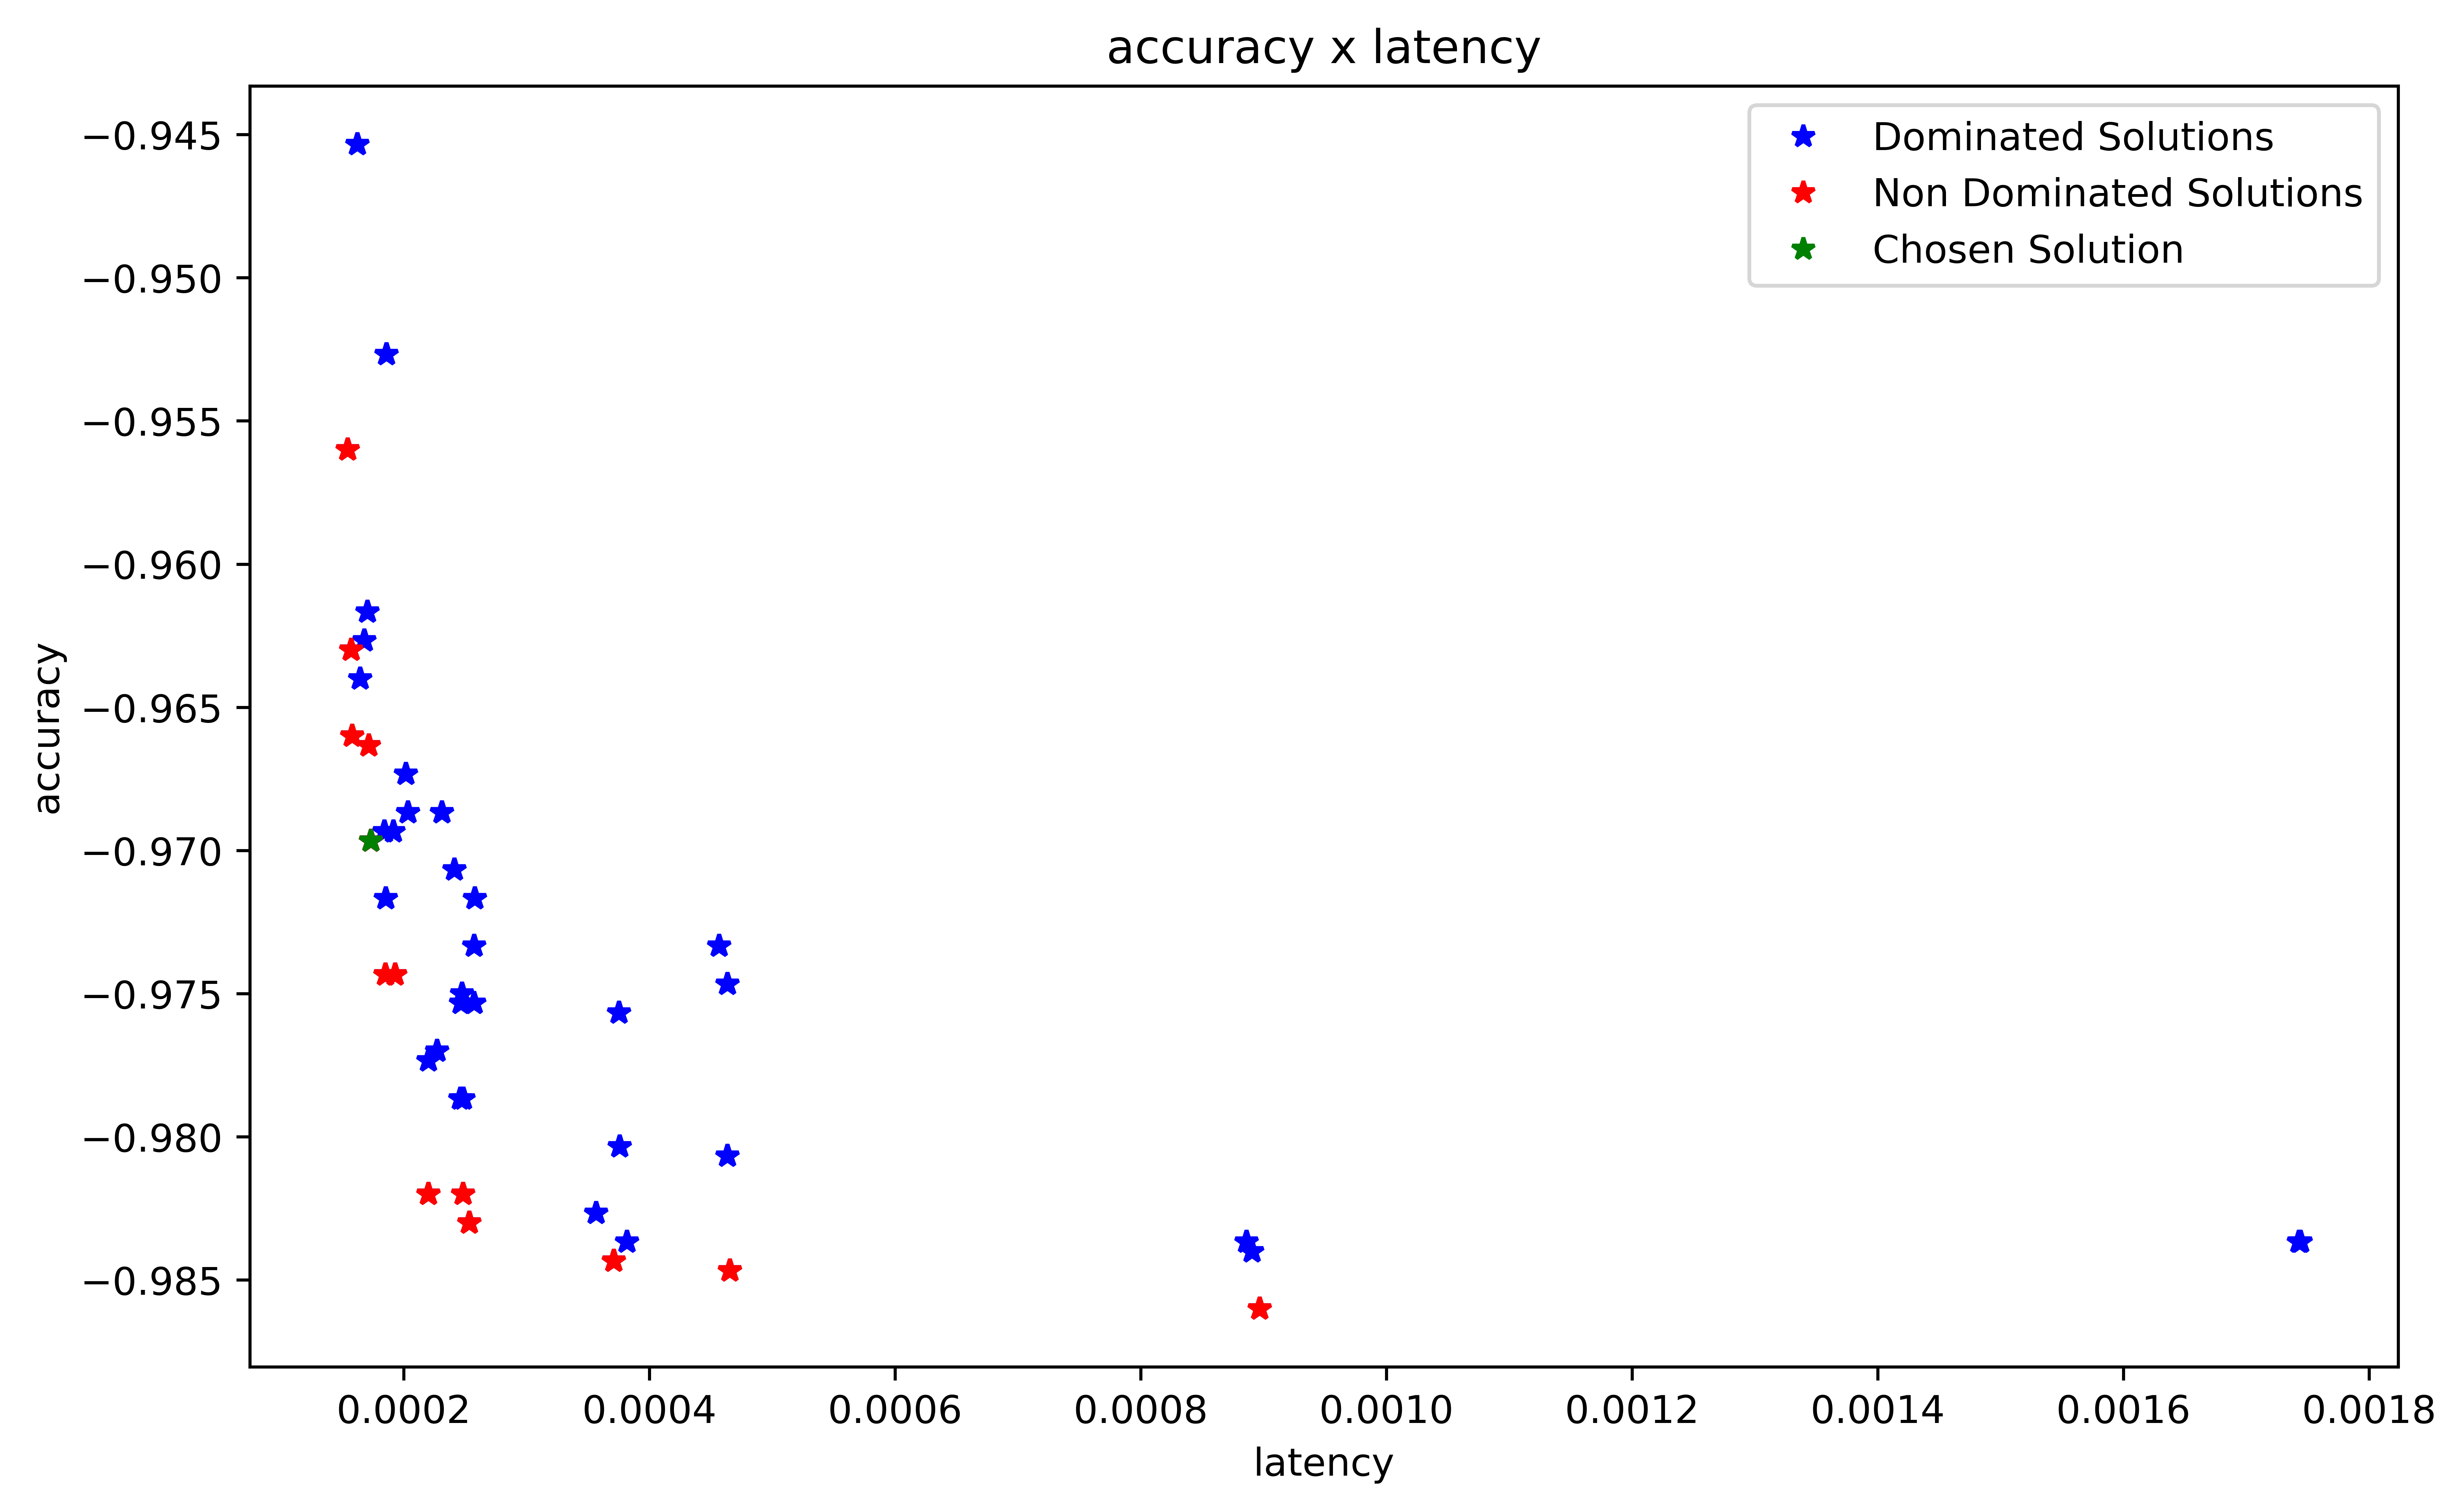

In [ ]:
first_objective = ("accuracy", 0.05)
second_objective = ("latency", 0.15)
ga = GeneticAlgorithm(
    population_size=12,
    X_train=train_images,
    X_test=test_images,
    y_train=train_labels,
    y_test=test_labels,
    first_objective=first_objective,
    second_objective=second_objective
)

result = ga.solve(generations=10)

result.model.save(f"{first_objective[0]}_{second_objective[0]}.h5")

Generation 0


100%|██████████| 12/12 [11:12<00:00, 56.04s/it]


G:0:
 loss: 0.05
 weights_norm: 31.15
  Genome: [1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
Generation 1


100%|██████████| 12/12 [08:47<00:00, 43.98s/it]


G:0:
 loss: 0.05
 weights_norm: 31.15
  Genome: [1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
Generation 2


100%|██████████| 12/12 [14:24<00:00, 72.06s/it]


G:2:
 loss: 0.05
 weights_norm: 40.15
  Genome: [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 3


100%|██████████| 12/12 [10:33<00:00, 52.78s/it]


G:2:
 loss: 0.05
 weights_norm: 40.15
  Genome: [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 4


100%|██████████| 12/12 [06:16<00:00, 31.40s/it]


G:2:
 loss: 0.05
 weights_norm: 40.15
  Genome: [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 5


100%|██████████| 12/12 [14:51<00:00, 74.26s/it] 


G:2:
 loss: 0.05
 weights_norm: 40.15
  Genome: [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 6


100%|██████████| 12/12 [08:23<00:00, 41.98s/it]


G:2:
 loss: 0.05
 weights_norm: 40.15
  Genome: [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 7


100%|██████████| 12/12 [11:49<00:00, 59.13s/it]


G:2:
 loss: 0.05
 weights_norm: 40.15
  Genome: [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 8


100%|██████████| 12/12 [14:23<00:00, 71.93s/it]


G:2:
 loss: 0.05
 weights_norm: 40.15
  Genome: [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 9


100%|██████████| 12/12 [09:15<00:00, 46.32s/it]


G:2:
 loss: 0.05
 weights_norm: 40.15
  Genome: [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Generation 10


100%|██████████| 12/12 [07:00<00:00, 35.00s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


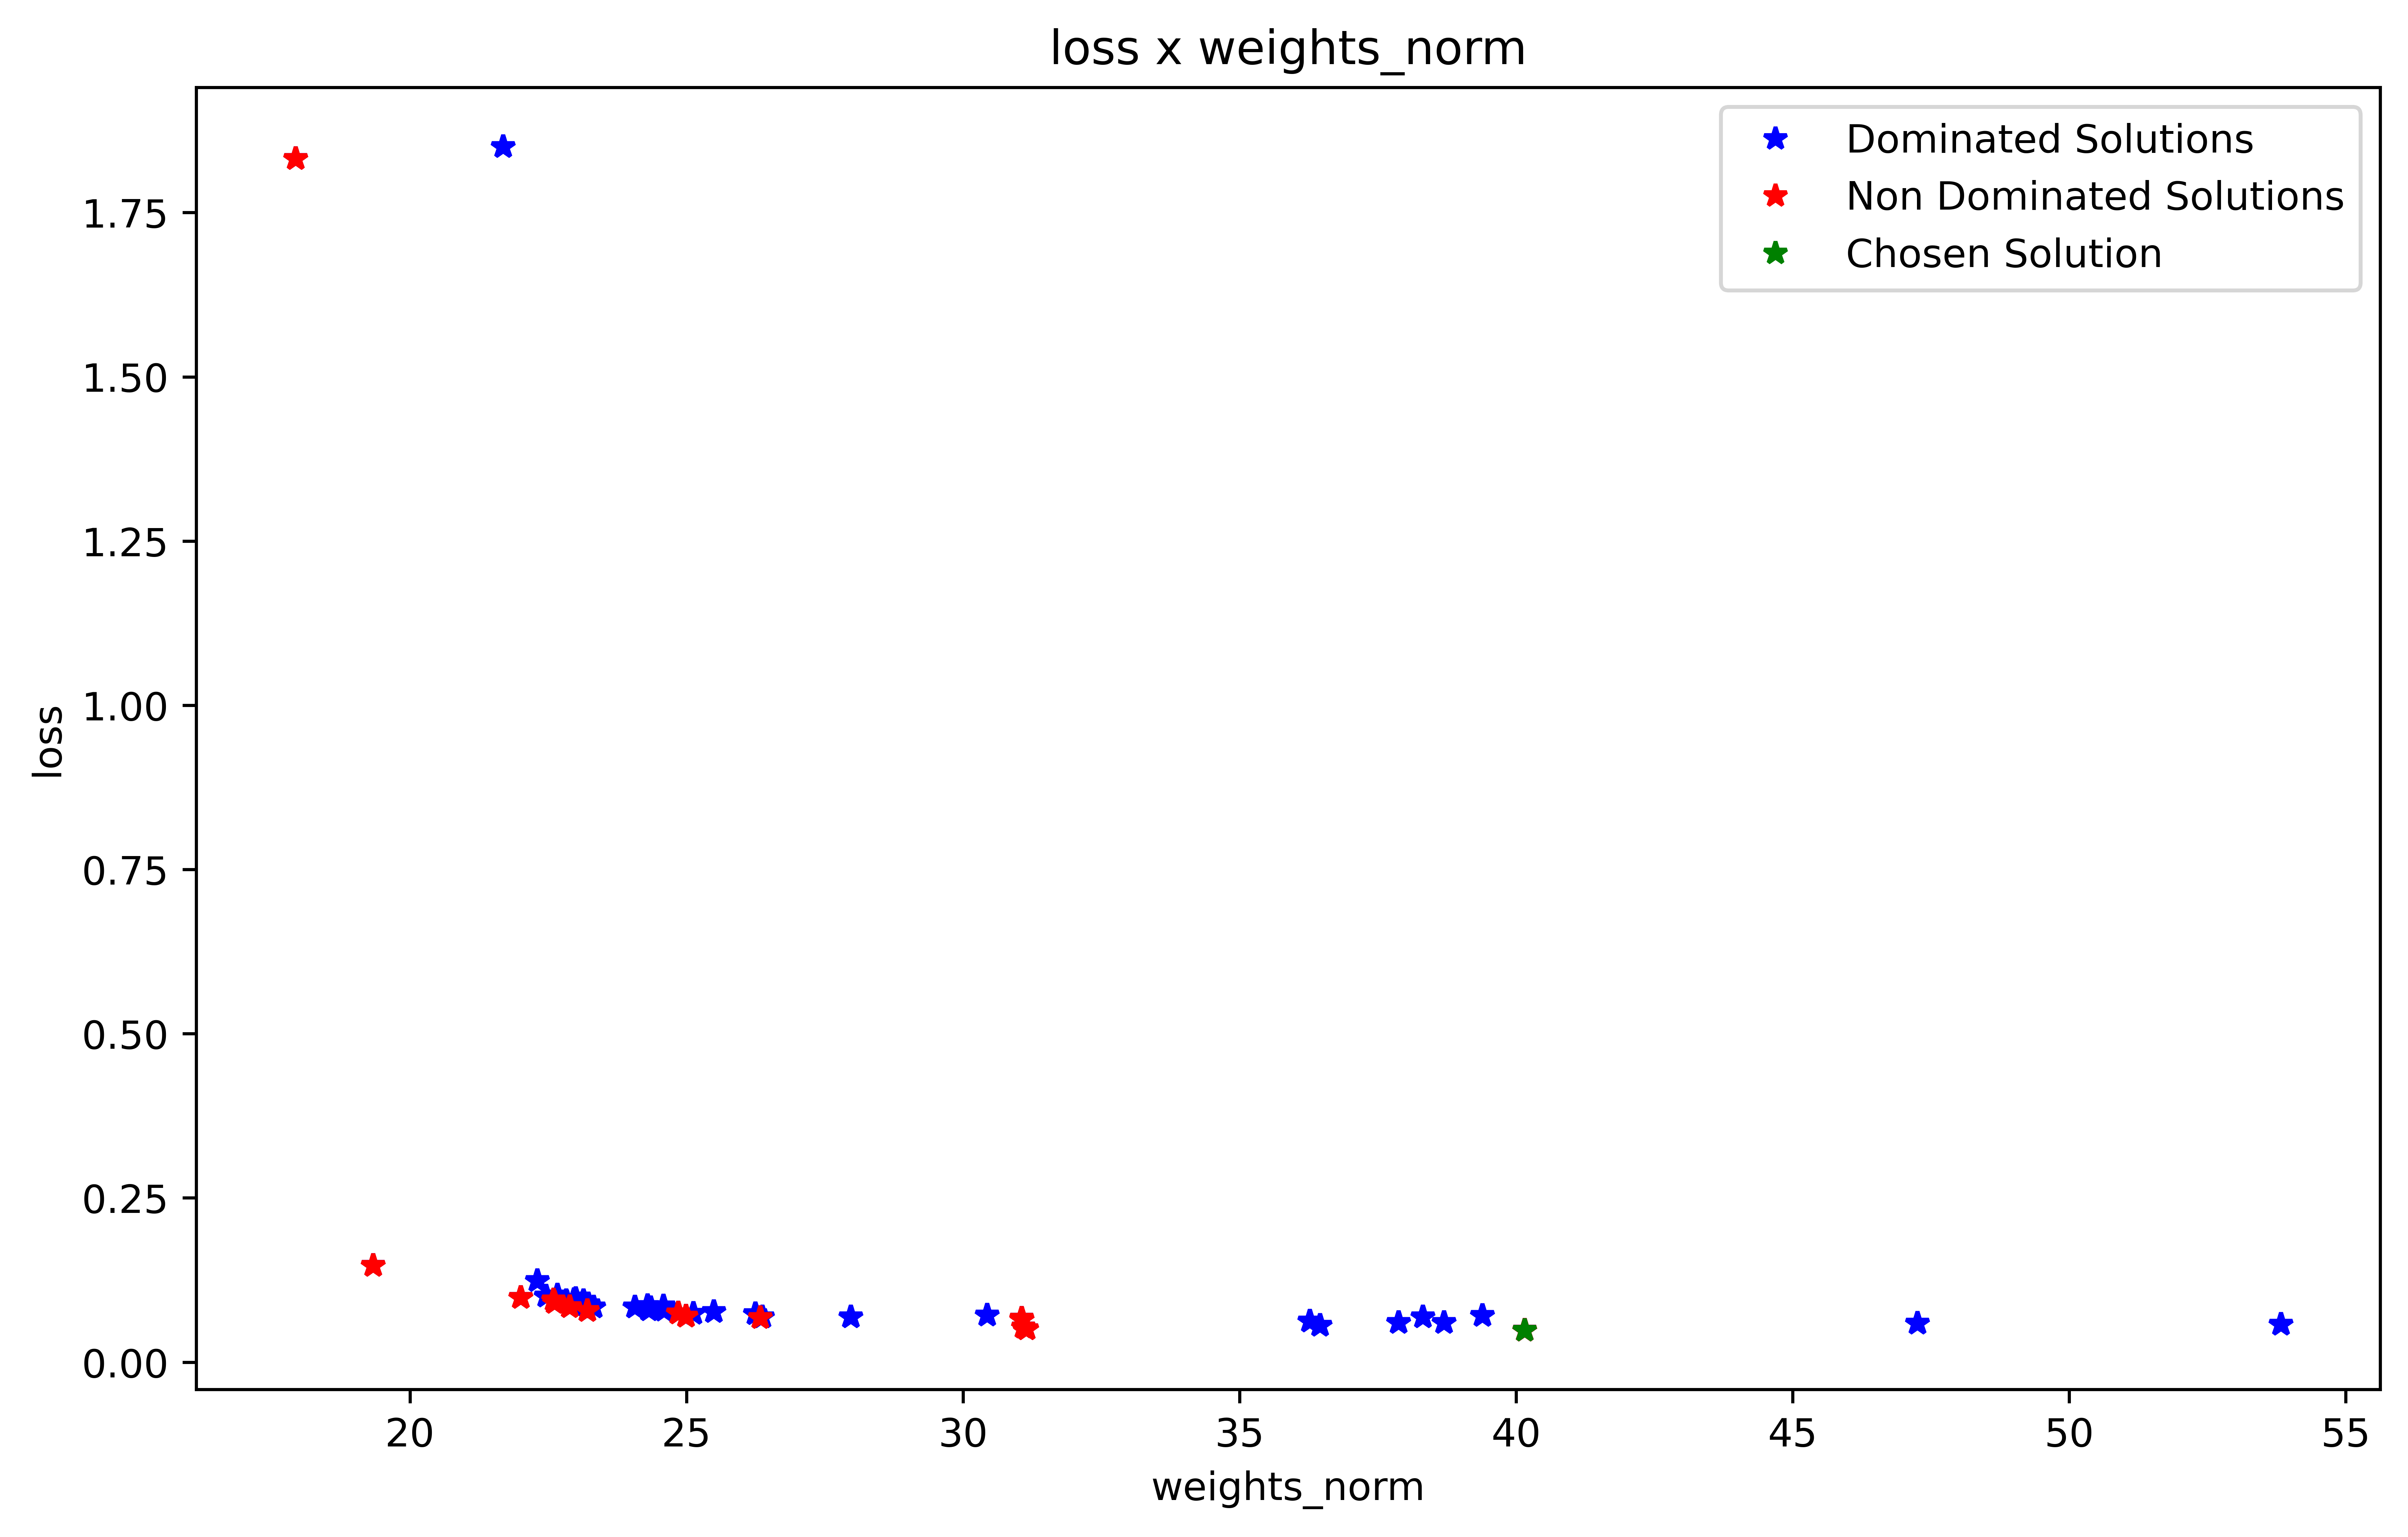

In [ ]:
first_objective = ("loss", 0.3)
second_objective = ("weights_norm", 0.3)
ga = GeneticAlgorithm(
    population_size=12,
    X_train=train_images,
    X_test=test_images,
    y_train=train_labels,
    y_test=test_labels,
    first_objective=first_objective,
    second_objective=second_objective
)

result = ga.solve(generations=10)

result.model.save(f"{first_objective[0]}_{second_objective[0]}.h5")

In [ ]:
first_objective = ("loss", 0.2)
second_objective = ("latency", 0.2)
ga = GeneticAlgorithm(
    population_size=12,
    X_train=train_images,
    X_test=test_images,
    y_train=train_labels,
    y_test=test_labels,
    first_objective=first_objective,
    second_objective=second_objective
)

result = ga.solve(generations=10)

result.model.save(f"{first_objective[0]}_{second_objective[0]}.h5")

Generation 0


100%|██████████| 12/12 [16:15<00:00, 81.26s/it] 


G:0:
 loss: 0.08
 latency: 0.0
  Genome: [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]
Generation 1


100%|██████████| 12/12 [17:48<00:00, 89.04s/it]


G:1:
 loss: 0.06
 latency: 0.0
  Genome: [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Generation 2


100%|██████████| 12/12 [10:23<00:00, 51.93s/it]


G:1:
 loss: 0.06
 latency: 0.0
  Genome: [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Generation 3


100%|██████████| 12/12 [17:38<00:00, 88.22s/it]


G:1:
 loss: 0.06
 latency: 0.0
  Genome: [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Generation 4


100%|██████████| 12/12 [20:33<00:00, 102.75s/it]


G:2:
 loss: 0.06
 latency: 0.0
  Genome: [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Generation 5


100%|██████████| 12/12 [13:04<00:00, 65.34s/it]


G:2:
 loss: 0.06
 latency: 0.0
  Genome: [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Generation 6


100%|██████████| 12/12 [11:09<00:00, 55.79s/it]


G:2:
 loss: 0.06
 latency: 0.0
  Genome: [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Generation 7


100%|██████████| 12/12 [11:14<00:00, 56.21s/it]


G:2:
 loss: 0.06
 latency: 0.0
  Genome: [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Generation 8


100%|██████████| 12/12 [17:24<00:00, 87.07s/it]


G:2:
 loss: 0.06
 latency: 0.0
  Genome: [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Generation 9


100%|██████████| 12/12 [07:48<00:00, 39.07s/it]


G:2:
 loss: 0.05
 latency: 0.0
  Genome: [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Generation 10


100%|██████████| 12/12 [15:45<00:00, 78.78s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
